### Setup

In [1]:
# Import required libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy as sp
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

In [2]:
# Set time range of 24 years
t = pd.date_range(start='31/10/2000', end='31/10/2024', freq='ME')

# Define column names for the equities
equity_columns = [
    'JOHNSON & JOHNSON',
    'BOSTON SCIENTIFIC',
    'ELI LILLY',
    'PFIZER', 
    'TELEFLEX',
    'CIGNA',
    'REVVITY',
    'MEDTRONIC', 
    'LABCORP HOLDINGS',
    'HUMANA'
    ]
    
# Generate lists for total return indices and market value indices
equity_TRI_columns = [f"{name} - TOT RETURN IND" for name in equity_columns]
equity_MV_columns  = [f"{name} - MARKET VALUE"   for name in equity_columns]

### Assignment 1

In [3]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Interest rates

# Download risk free interest rates (skipping rows 1,2 because they are not actual market values but additional information)
rF_yearly = pd.read_excel('Data/INTEREST_RATE.xlsx', usecols=['US FEDERAL FUNDS RATE (MONTHLY AVERAGE) NADJ'], skiprows=[1, 2], header=0)

# Verify there are no NaN values in the DataFrame
assert not rF_yearly.isnull().values.any(), "DataFrame contains NaN values"

# Adding a missing value for October 2024, required since other files contain this data. 
# Source: https://www.federalreserve.gov/releases/h15/
rF_yearly.loc[len(rF_yearly)] = 4.92

# Compute monthly rates
rF = np.array(rF_yearly / 12)

#-----------------------------------------------------------------------------------------------------------------------------------#
# Market indices

# Download overall equity market index
health_MKT = pd.read_excel('Data/STOXX_HEALTH_PI.xlsx', usecols=['STOXX NTH AMER 600 HEALTH CARE E - PRICE INDEX'])

# Verify there are no NaN values in the DataFrame
assert not health_MKT.isnull().values.any(), "DataFrame contains NaN values"

# Conversion in percentual montlhy variance
rMKT = 100 * (np.log(health_MKT) - np.log(health_MKT.shift(1)))

# Drop the first row (since log returns are computed as difference between consecutive data, first row will be NaN)
# Calculation of Excess Market Returns from risk-free Market Returns
rMKT = np.array(rMKT[1:])
eMKT = np.subtract(rMKT, rF[1:])

#-----------------------------------------------------------------------------------------------------------------------------------#
# Market value of constituents

# Download market value of constituents
mkt_value = pd.read_excel('Data/MKT_VALUE.xlsx', usecols=equity_MV_columns, skiprows=[1, 2], header=0)
# Reorder the columns explicitly to match the correct order 
mkt_value = mkt_value[equity_MV_columns]

# Verify there are no NaN values in the DataFrame
assert not mkt_value.isnull().values.any(), "DataFrame contains NaN values"

#-----------------------------------------------------------------------------------------------------------------------------------#
# Equities

# Download equities
data = pd.read_excel('Data/Stocks_Constituents.xlsx', usecols=equity_TRI_columns)
# Reorder the columns explicitly to match the correct order 
data = data[equity_TRI_columns]
# Verify there are no NaN values in the DataFrame
assert not data.isnull().values.any(), "DataFrame contains NaN values"

### Assignment 2

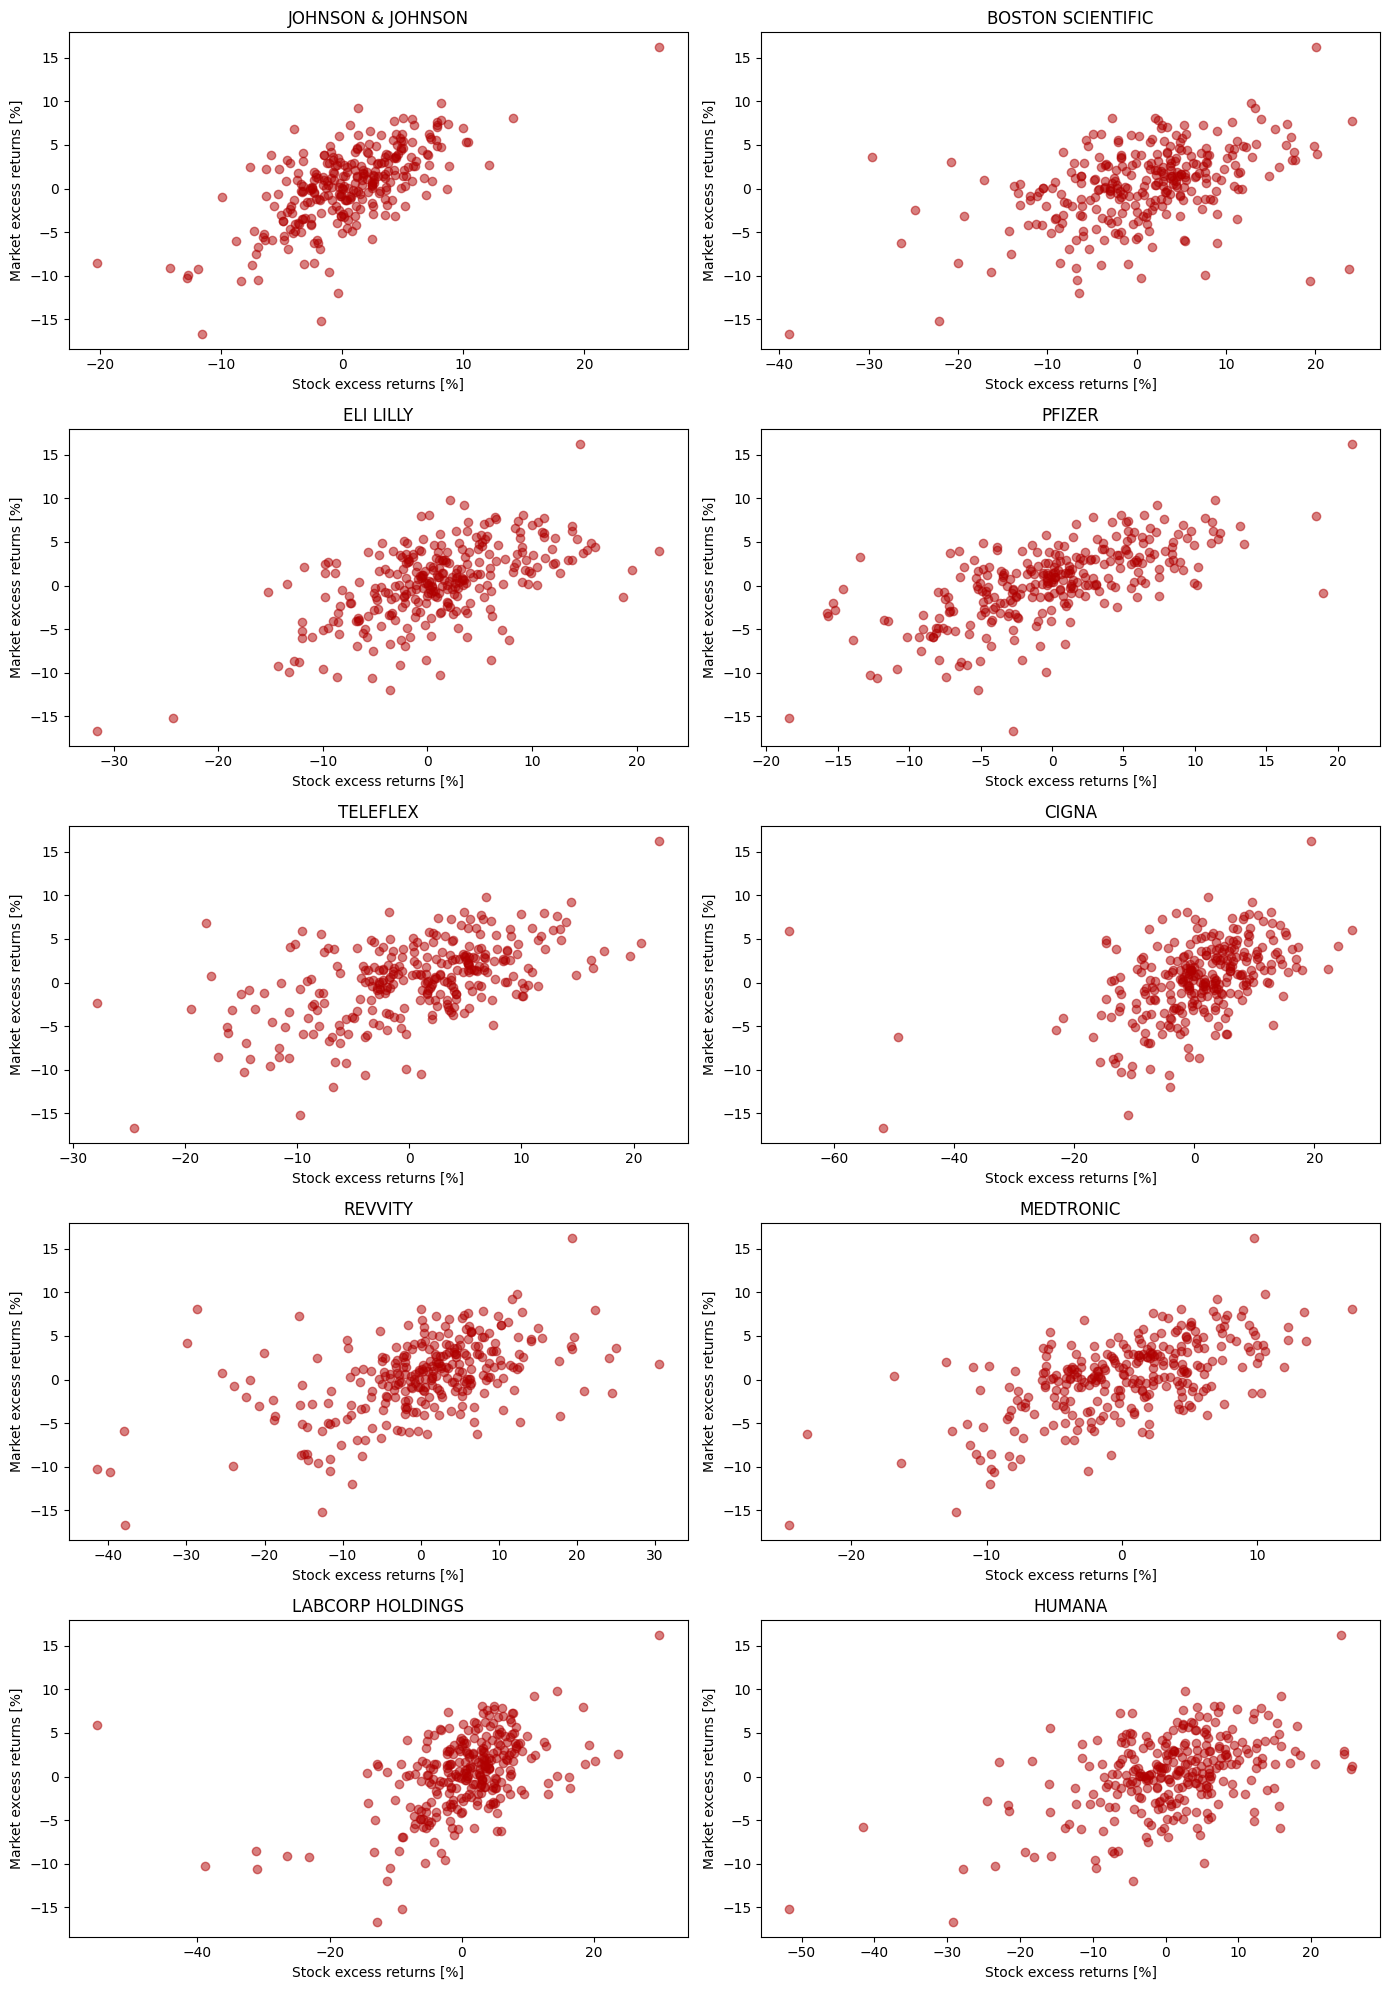

In [4]:
# Calculate the log returns for all equities
log_returns = 100 * (np.log(data) - np.log(data.shift(1)))

# Drop the first row (since log returns are computed as difference between consecutive data, first row will be NaN)
log_returns = log_returns.iloc[1:]

# Verify there are no other NaN values in the DataFrame
assert not log_returns.isnull().values.any(), "DataFrame contains NaN values"

# Broadcasting rF across columns in log_return to create the result dataframe
eEquities = log_returns.sub(rF[1:], axis=0)

#-----------------------------------------------------------------------------------------------------------------------------------#
# Create scatter plots

# Get number of equities
num_equities = eEquities.shape[1]  

# Calculate the number of rows needed with two plots per row (creating an extra row if there's an odd number of equities)
num_rows  = (num_equities + 1) // 2  

# Create the figure and axis grid
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 4 * num_rows))
# Flatten the grid for easy indexing
axes      = axes.flatten() 

# Loop through each equity column and create a scatter plot
for i, column in enumerate(eEquities.columns):
    axes[i].scatter(eEquities[column], eMKT, alpha=0.5, color='#b00000')
    axes[i].set_title(equity_columns[i])
    axes[i].set_xlabel('Stock excess returns [%]')
    axes[i].set_ylabel('Market excess returns [%]')

# Hide any unused subplots if the number of equities is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Make sure the layout is pretty
plt.tight_layout()
plt.savefig('Results/equities_scatterplot.png')
plt.show()

### Assignment 3

Regression summaries have been saved to Results/stocks_regression_summaries.txt


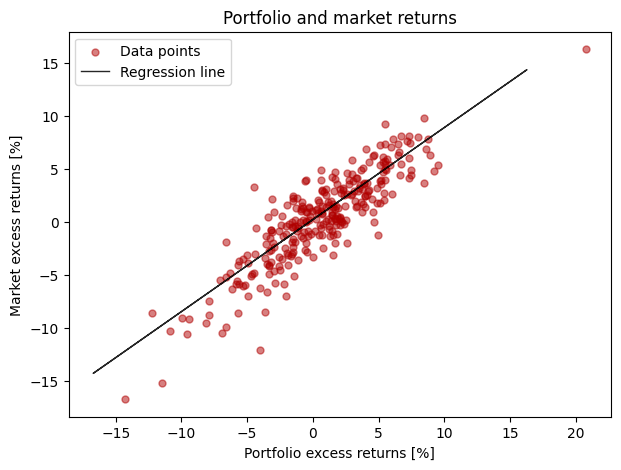

In [5]:
# Adds an intercept (constant) term to eMKT
eMKT_with_const   = sm.add_constant(eMKT)

# Perform regressions
regression_models = [sm.OLS(eEquities[column], eMKT_with_const).fit() for column in eEquities.columns]

# Define the file name
output_file       = "Results/stocks_regression_summaries.txt"

# Open the file in write mode
with open(output_file, "w") as f:
    for i, model in enumerate(regression_models):
        # Write the equity name and the summary to the file
        f.write(f"Summary for {equity_columns[i]}:\n")
        # Convert the summary to a string format
        f.write(model.summary().as_text())
        # Separator between summaries to improve readability
        f.write("\n\n" + "<->:"*24 + "\n\n")  

print(f"Regression summaries have been saved to {output_file}")

#-----------------------------------------------------------------------------------------------------------------------------------#
# Perform linear regression on the portfolio

# Compute the weights
weights           = mkt_value.div(mkt_value.sum(axis=1), axis=0)
# Rename columns in both DataFrames so that pandas doesn't cry when performing element-wise multilpication 
weights.columns   = equity_columns
eEquities.columns = equity_columns
# Compute weighted average
avg_return        = weights[1:] * eEquities
# Sum across columns to get the portfolio return for each row
ePortfolio        = avg_return.sum(axis=1)

# Perform regression 
regression_model  = sm.OLS(ePortfolio, eMKT_with_const).fit()

#-----------------------------------------------------------------------------------------------------------------------------------#
# Produce a scatterplot

plt.figure(figsize=(7, 5))
plt.scatter(ePortfolio, eMKT, alpha=0.5, color='#b00000', s=25, label='Data points')
plt.plot(eMKT, regression_model.fittedvalues, color='0', linewidth=1, alpha=0.85, label="Regression line")
plt.legend()
plt.xlabel("Portfolio excess returns [%]")
plt.ylabel("Market excess returns [%]")
plt.title("Portfolio and market returns")
plt.savefig('Results/portfolio_regression.png', dpi=300)
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------#
# Save summary in external file

output_file = 'Results/portfolio_regression_summary.txt'

with open(output_file, "w") as f:
    f.write(f"Summary for Porfolio:\n")
    # Convert the summary to a string format
    f.write(model.summary().as_text())

### Assignment 4

In [20]:
for i, col in enumerate(eEquities.columns):
    print(f"Performing diagnostic tests for {col}")

    # Extract data for the test
    ePortfolio = eEquities[col]  
    eMKT       = eMKT_with_const[:, 1]  

    # Original regression
    regression_model = sm.OLS(ePortfolio, sm.add_constant(eMKT)).fit()
    fit1             = regression_model.fittedvalues

    # Auxiliary regression
    XR   = np.column_stack((np.ones_like(ePortfolio), eMKT, np.power(fit1, 2), np.power(fit1, 3)))
    Res2 = sm.OLS(ePortfolio, XR).fit()

    # Calculation of statistics
    RSSR  = regression_model.ssr
    RSSU  = Res2.ssr  
    n_obs = len(ePortfolio)
    df_numerator   = 2
    df_denominator = n_obs - (2 + 2)
    Fstat = ((RSSR - RSSU) / df_numerator) / (RSSU / df_denominator)
    Pval  = 1 - sp.stats.f.cdf(Fstat, df_numerator, df_denominator)
    print(f"Equity: {col}, F-statistic: {Fstat}, p-value: {Pval}")

    # Using residuals and independent variables for the White test
    rs        = regression_model.resid
    whitetest = sm.stats.diagnostic.het_white(rs, sm.add_constant(eMKT))
    print("White test p-value:", whitetest[1])

    # Breusch-Godfrey test for autocorrelation (with nlags=3 as specified)
    bgtest = sm.stats.diagnostic.acorr_breusch_godfrey(regression_model, nlags=3)
    print("Breusch-Godfrey test p-value:", bgtest[1])

    # Re-run the OLS model with HAC standard errors (maxlags=1)
    Res2 = sm.OLS(ePortfolio, eMKT).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    print(Res2.summary())

    # Standard OLS fit
    Res3 = sm.OLS(ePortfolio, eMKT).fit()

    # Adjusted model with HAC standard errors using get_robustcov_results
    Res4 = Res3.get_robustcov_results(cov_type='HAC', maxlags=1)
    print(Res4.summary())


Performing diagnostic tests for JOHNSON & JOHNSON
Equity: JOHNSON & JOHNSON, F-statistic: 4.953517082558805, p-value: 0.007680457397266083
White test p-value: 7.191383011310817e-10
Breusch-Godfrey test p-value: 0.17790190932253802
                                 OLS Regression Results                                
Dep. Variable:      JOHNSON & JOHNSON   R-squared (uncentered):                   0.458
Model:                            OLS   Adj. R-squared (uncentered):              0.456
Method:                 Least Squares   F-statistic:                              91.13
Date:                Tue, 19 Nov 2024   Prob (F-statistic):                    6.19e-19
Time:                        21:26:16   Log-Likelihood:                         -775.75
No. Observations:                 288   AIC:                                      1553.
Df Residuals:                     287   BIC:                                      1557.
Df Model:                           1                            

### Assignment 5

In [8]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Perform chow test 

# Specify the degrees of freedom of the model
dof   = 2
# Initialize the list that will contain the P-values of all equities
Pvals = []
# Define the total number of data points for each equity
T     = len(eEquities)
# Set minimum dimension of subset to use for unrestricted models
width = int(0.1 * T)
# Set extremes of the intervals for regression
begin = width
end   = T - width

# Loop over equities 
for column in eEquities.columns:
    # Perform regression on the whole dataset for the considered equity
    Res1  = sm.OLS(eEquities[column][1:T], eMKT_with_const[1:T]).fit()
    # Compute residual sum of squares for restricted model
    RSSR  = Res1.ssr
    # Preemptively allocate memory to store the results in order to speed up computations
    Fstat = np.empty(end - begin - 1, dtype=float)
    Pval  = np.empty(end - begin - 1, dtype=float)

    # Loop for dates within interval 
    for i, date in enumerate(range(begin + 1, end)):
        X1 = np.column_stack((np.ones_like(eMKT[1:date]), eMKT[1:date]))
        X2 = np.column_stack((np.ones_like(eMKT[date + 1:T]), eMKT[date + 1:T]))
        
        # Compute residual sum of squares for unrestricted model as sum of residuals of the two regressions
        res2A = sm.OLS(eEquities[column][1:date], X1).fit()
        res2B = sm.OLS(eEquities[column][date + 1:T], X2).fit()
        RSSU  = res2A.ssr + res2B.ssr
        
        # Save Fstat and Pval for the adjusted index `i`
        Fstat[i] = ((RSSR - RSSU) / dof) / (RSSU / (T - 2 * dof))
        Pval[i]  = 1 - sp.stats.f.cdf(Fstat[i], dof, T - 2 * dof)

    # Append P-values to list of results for all equities
    Pvals.append(Pval)


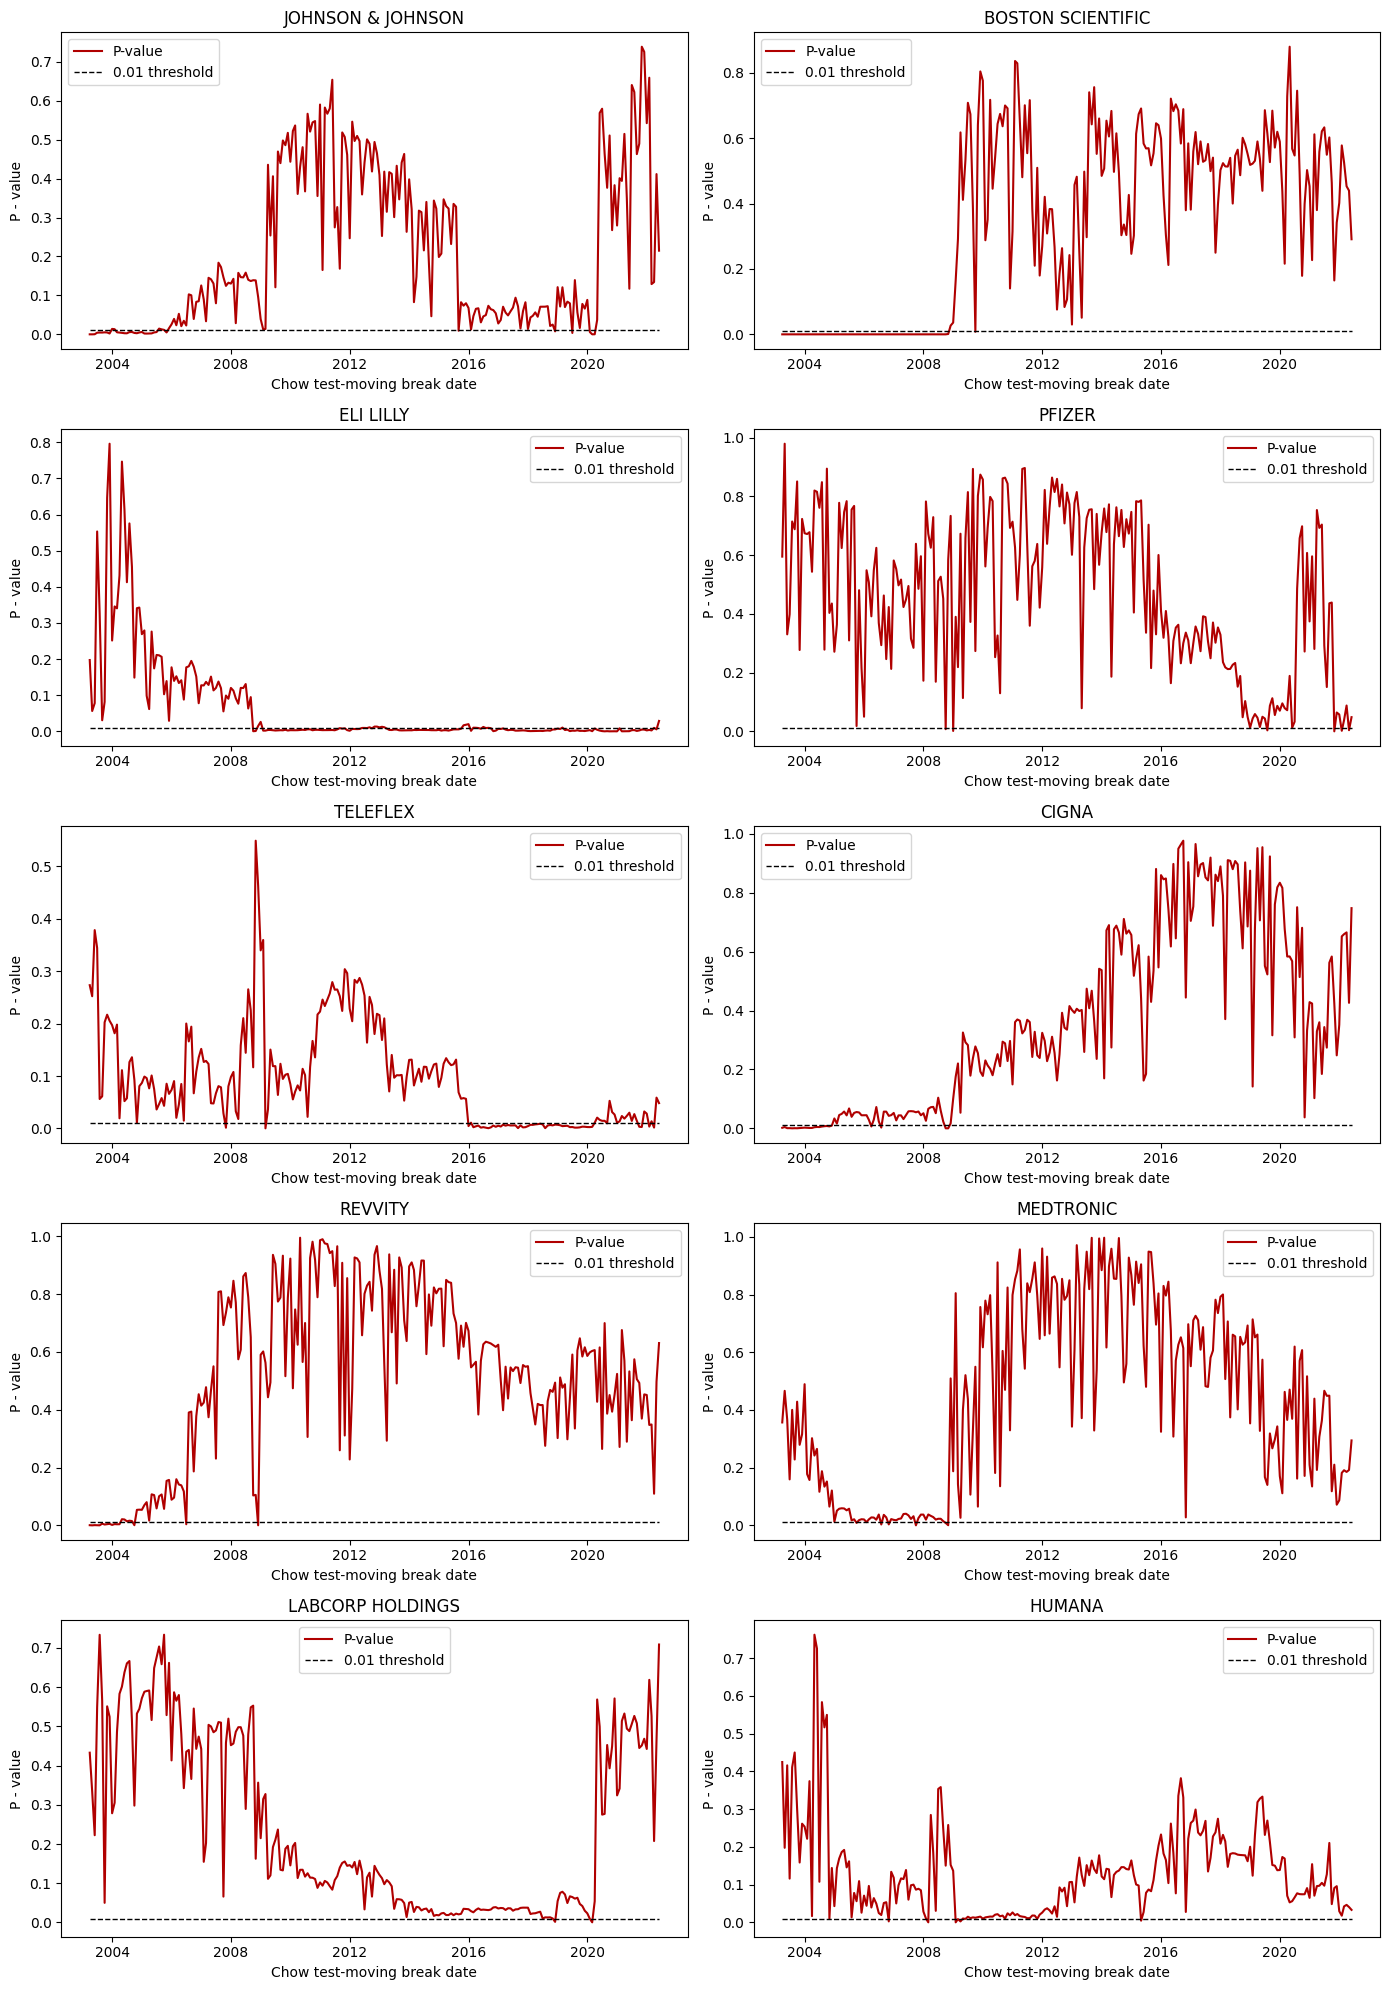

In [9]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Plot results

# Get the number of equities
num_equities = len(Pvals)
# Calculate the number of rows needed with two plots per row
num_rows  = (num_equities + 1) // 2
# Create the figure and axis grid
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 4 * num_rows))
# Flatten the grid for easy indexing
axes      = axes.flatten() 
# Select the subset of dates to use as x axis
t_subset  = t[begin + 1:end]
# Plot each equity's p-values with the date-based x-axis
for i, (pvals, column) in enumerate(zip(Pvals, eEquities.columns)):
    # Plot p-values for each equity on its respective axis using the date range
    axes[i].plot(t_subset, pvals, label="P-value", color="#b00000")
    axes[i].plot(t_subset, 0.01 * np.ones_like(pvals), label="0.01 threshold", color="0", linestyle="--", linewidth=1)
    
    # Label the plot and add a title
    axes[i].set_title(f"{column}")
    axes[i].set_xlabel('Chow test-moving break date')
    axes[i].set_ylabel('P - value')
    axes[i].legend()
    
# Remove any empty subplots if the number of equities is odd
if num_equities % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout and save the figure
plt.tight_layout()
#plt.savefig('Results/chowmoving.png', dpi=300)
plt.show()

In [10]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Temporary: automated check for structural breaks
#-----------------------------------------------------------------------------------------------------------------------------------#
# Save dates indices of structural break 

# Initialize a list to store the indices of significant p-values for each equity
significant_indices = []

# Loop through each equity's p-values in Pvals
for pvals in Pvals:
    # Find indices where p-value is less than 0.01
    indices = np.where(pvals < 0.01)[0]  # [0] extracts indices as an array
    # Append the result
    significant_indices.append(indices)

#-----------------------------------------------------------------------------------------------------------------------------------#
# Filter only sequences of consecutive indices with length > min_length

# Threshold value for minimum length of consecutive sequences
min_length = 3

# Initialize a new list to store the filtered significant indices
filtered_significant_indices = []

# Loop over list of potential structural break for every equity
for indices in significant_indices:
    filtered_indices = []
    # If indices array is empty, continue to next equity
    if len(indices) == 0:
        filtered_significant_indices.append(np.array([]))
        continue

    #### Identify consecutive sequences of indices
    
    # Start the first sequence with the first index
    temp_sequence = [indices[0]]  

    for i in range(1, len(indices)):
        # Check if the current index is consecutive with the previous one
        if indices[i] == indices[i - 1] + 1:
            # Add to the current sequence if consecutive
            temp_sequence.append(indices[i])
        else:
            # If sequence ends, check length and add to filtered_indices if it meets the threshold
            if len(temp_sequence) >= min_length:
                filtered_indices.extend(temp_sequence)
            # Start a new sequence
            temp_sequence = [indices[i]]

    # Check the last sequence after the loop ends
    if len(temp_sequence) >= min_length:
        filtered_indices.extend(temp_sequence)

    # Append the filtered indices for the current equity
    filtered_significant_indices.append(np.array(filtered_indices))

### Assignment 6

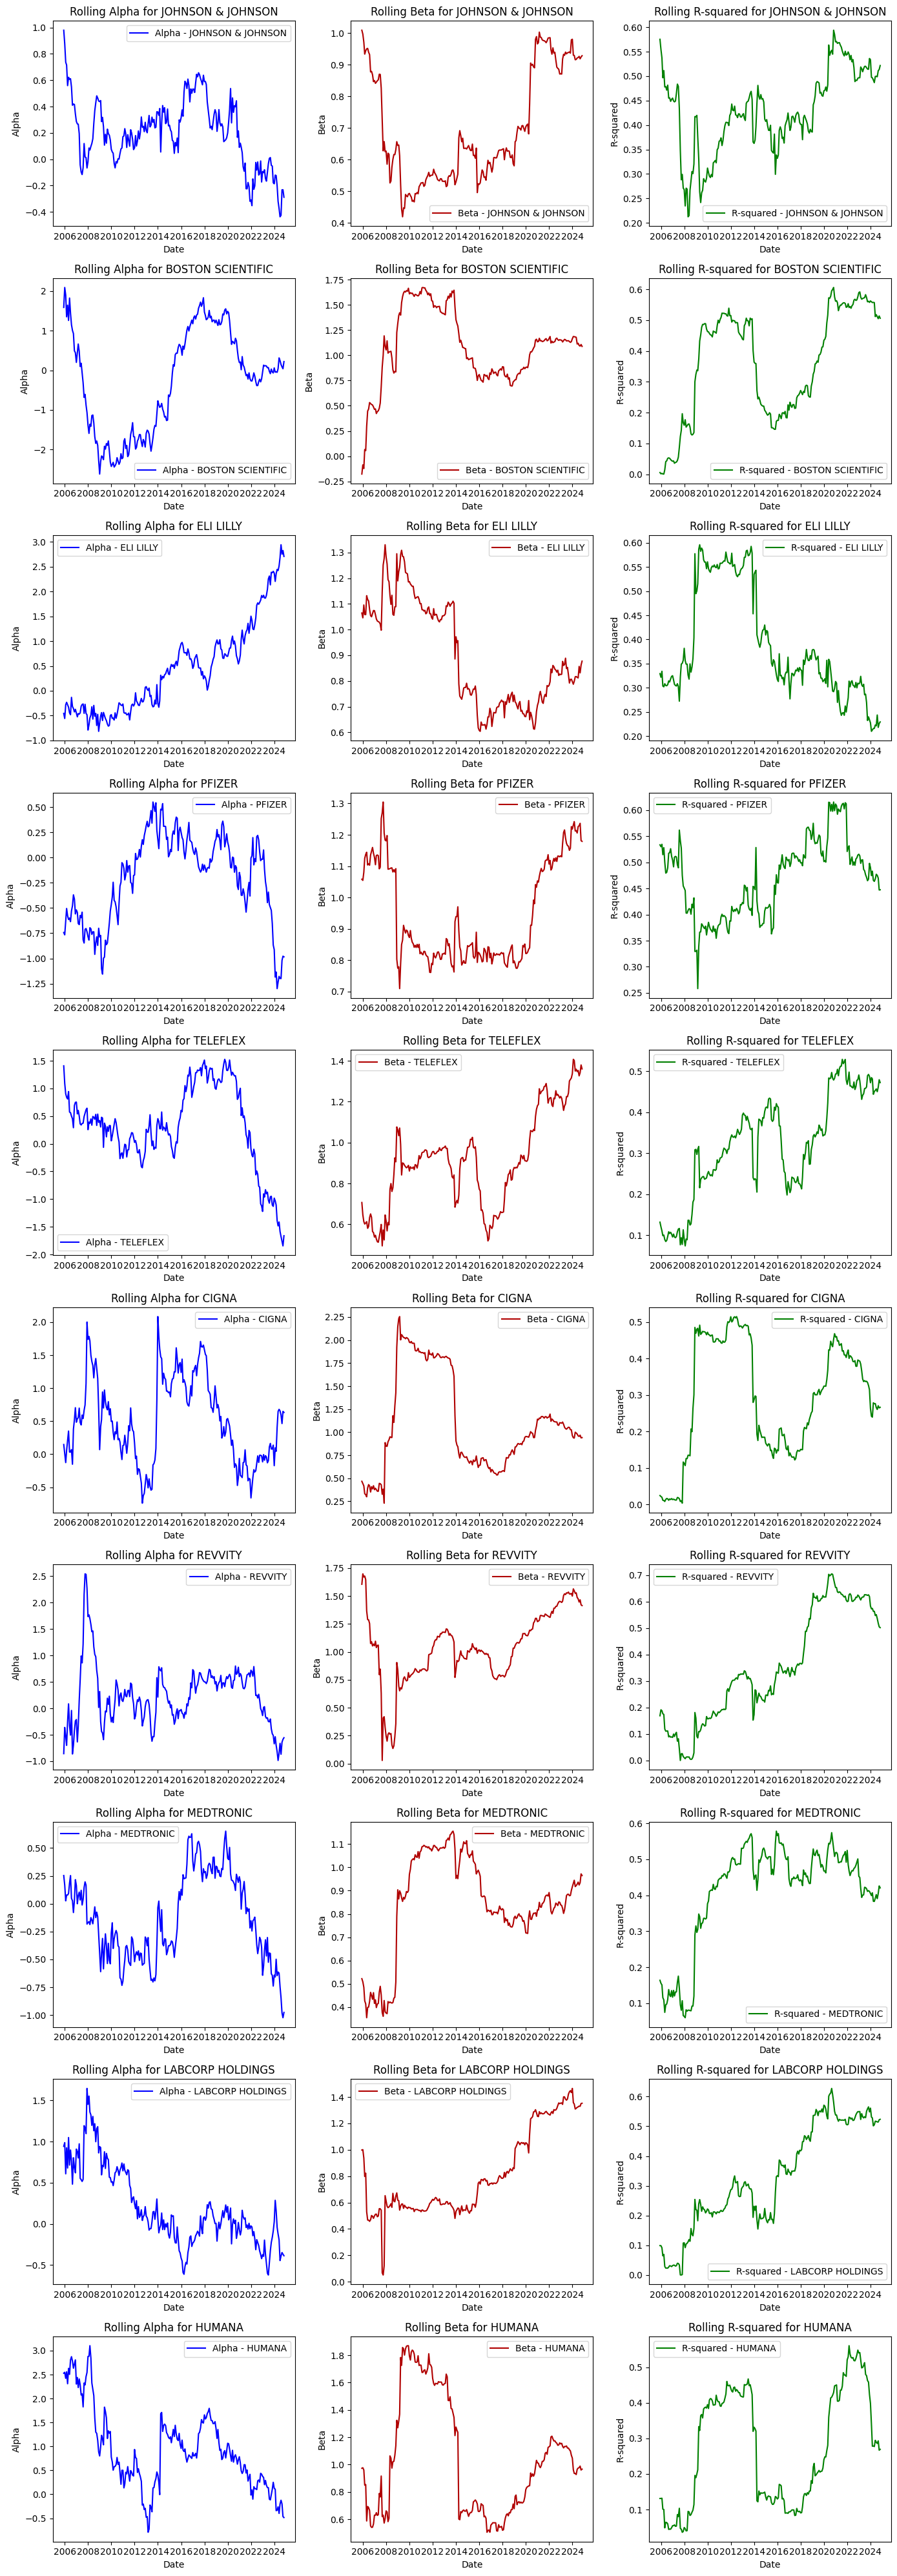

In [11]:
# Define parameters for rolling window
window_size  = 60  # 5 years in months
num_months   = len(eEquities)
results_dict = {}
Date         = pd.date_range(start='30/11/2005', end='31/10/2024', freq='ME')

#-----------------------------------------------------------------------------------------------------------------------------------#
# Compute rolling quantities

# Loop over time instants within window size
for start in range(num_months - window_size):
    end = start + window_size
    
    equities_window      = eEquities.iloc[start:end] 
    market_excess_window = eMKT[start:end]
            
    X = sm.add_constant(market_excess_window)
    
    for column in equities_window.columns:
        y = equities_window[column].values
        
        window_model = sm.OLS(y, X).fit()
       
        # Creating new keys for the dictionary
        if f'Alpha {column}' not in results_dict:
            results_dict[f'Alpha {column}']     = []
            results_dict[f'Beta {column}']      = []
            results_dict[f'R_squared {column}'] = []
       
        # Storing the results
        results_dict[f'Alpha {column}'    ].append(window_model.params[0])  
        results_dict[f'Beta {column}'     ].append(window_model.params[1])    
        results_dict[f'R_squared {column}'].append(window_model.rsquared)  

#-----------------------------------------------------------------------------------------------------------------------------------#
# Plot quantities

# Convert results to a DataFrame for easier plotting
results_df   = pd.DataFrame(results_dict)
    
# Plotting results
num_equities = len(equities_window.columns)

fig, axes    = plt.subplots(num_equities, 3, figsize=(14, num_equities * 4))  

for i, column in enumerate(equities_window.columns):
    # Plot Alpha
    axes[i, 0].plot(Date, results_df[f'Alpha {column}'], label=f'Alpha - {column}', color='blue')
    axes[i, 0].set_title(f'Rolling Alpha for {column}')
    axes[i, 0].set_xlabel('Date')
    axes[i, 0].set_ylabel('Alpha')
    axes[i, 0].legend()
        
    # Plot Beta
    axes[i, 1].plot(Date, results_df[f'Beta {column}'], label=f'Beta - {column}', color='#b00000')
    axes[i, 1].set_title(f'Rolling Beta for {column}')
    axes[i, 1].set_xlabel('Date')
    axes[i, 1].set_ylabel('Beta')
    axes[i, 1].legend()
    
    # Plot R-squared
    axes[i, 2].plot(Date, results_df[f'R_squared {column}'], label=f'R-squared - {column}', color='green')
    axes[i, 2].set_title(f'Rolling R-squared for {column}')
    axes[i, 2].set_xlabel('Date')
    axes[i, 2].set_ylabel('R-squared')
    axes[i, 2].legend()

plt.tight_layout()
plt.savefig('Results/rolling_quantities.png')
plt.show()

### Assignment 7

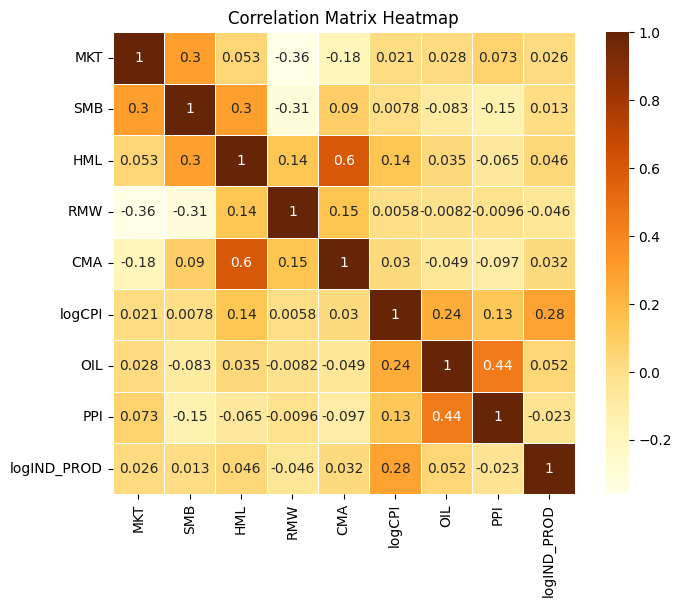

In [12]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Define variables used in the multi-variate regression

FF5 = pd.read_excel('Data/FF5.xlsx')
CPI = pd.read_excel('Data/CPI.xlsx')

MKT = pd.read_excel('Data/FF5.xlsx', usecols=['Mkt-RF'])
SMB = pd.read_excel('Data/FF5.xlsx', usecols=['SMB'])
HML = pd.read_excel('Data/FF5.xlsx', usecols=['HML'])
CMA = pd.read_excel('Data/FF5.xlsx', usecols=['CMA'])
RMW = pd.read_excel('Data/FF5.xlsx', usecols=['RMW'])
OIL = pd.read_excel('Data/CPI.xlsx', usecols=['OIL'])
CPI = pd.read_excel('Data/CPI.xlsx', usecols=['CPI'])
PPI = pd.read_excel('Data/CPI.xlsx', usecols=['PPI CHEMICAL'])
IND_PROD = pd.read_excel('Data/CPI.xlsx', usecols=['US INDUSTRIAL PRODUCTION - MANUFACTURING (NAICS) VOLA'])

logCPI = 100 * (np.log(CPI) - np.log(CPI.shift(1)))
logIND_PROD = 100 * (np.log(IND_PROD) - np.log(IND_PROD.shift(1)))

#-----------------------------------------------------------------------------------------------------------------------------------#
# Actual regression

# Dependent variable for multi-variate regression (trunkated so that )
Y = ePortfolio[4:]
# Independent variables for multi-variate regression 
X = np.column_stack((np.ones_like(Y) , MKT[1:], SMB[1:] , HML[1:] , RMW[1:], CMA[1:],
                    logCPI[1:], OIL[1:], PPI[1:], logIND_PROD[1:]))
# Perform regression
Res1 = sm.OLS(Y , X).fit()

#-----------------------------------------------------------------------------------------------------------------------------------#
# Save summary in external file

output_file = 'Results/multivariate_regression_summary.txt'
with open(output_file, "w") as f:
    # Convert the summary to a string format
    f.write(model.summary().as_text())

#-----------------------------------------------------------------------------------------------------------------------------------#
# Save summary in external file

data = np.column_stack((MKT[1:], SMB[1:] , HML[1:] , RMW[1:], CMA[1:], logCPI[1:], OIL[1:], PPI[1:], logIND_PROD[1:]))
df   = pd.DataFrame(data, columns=['MKT', 'SMB', 'HML', 'RMW', 'CMA', 'logCPI', 'OIL', 'PPI', 'logIND_PROD'])
# Calculating the correlation matrix
corr_matrix = df.corr()

#-----------------------------------------------------------------------------------------------------------------------------------#
# Save correlation matrix

output_file = 'Results/correlation_matrix.txt'
with open(output_file, "w") as f:
    # Convert the summary to a string format
    f.write(model.summary().as_text())

#-----------------------------------------------------------------------------------------------------------------------------------#
# Plot correlation matrix in a very pleasant way
vmin, vmax = corr_matrix.min().min(), corr_matrix.max().max()
centre     = (vmax + vmin)/2
palette    = sns.color_palette("YlOrBr", as_cmap=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap=palette, center=centre, linewidths=0.5, square=True)
plt.title("Correlation Matrix Heatmap")
plt.savefig('Results/Correlation_heatmap.png')
plt.show()

In [13]:
# Define new set of variables to use
X_best = np.column_stack((np.ones_like(Y), eMKT[4:], MKT[1:], SMB[1:], CMA[1:], logIND_PROD[1:]))
# Perform new multivariate regression
Res2 = sm.OLS(Y , X).fit()
# Obtain residuals
RSSU = Res1.ssr
RSSR = Res2.ssr
# Get P-value
Fstat =(( RSSR - RSSU ) /5) /( RSSU /(273) )
Pval =1 - sp.stats.f.cdf(Fstat, 5, 273)
print(f"p-value={Pval}")


p-value=1.0


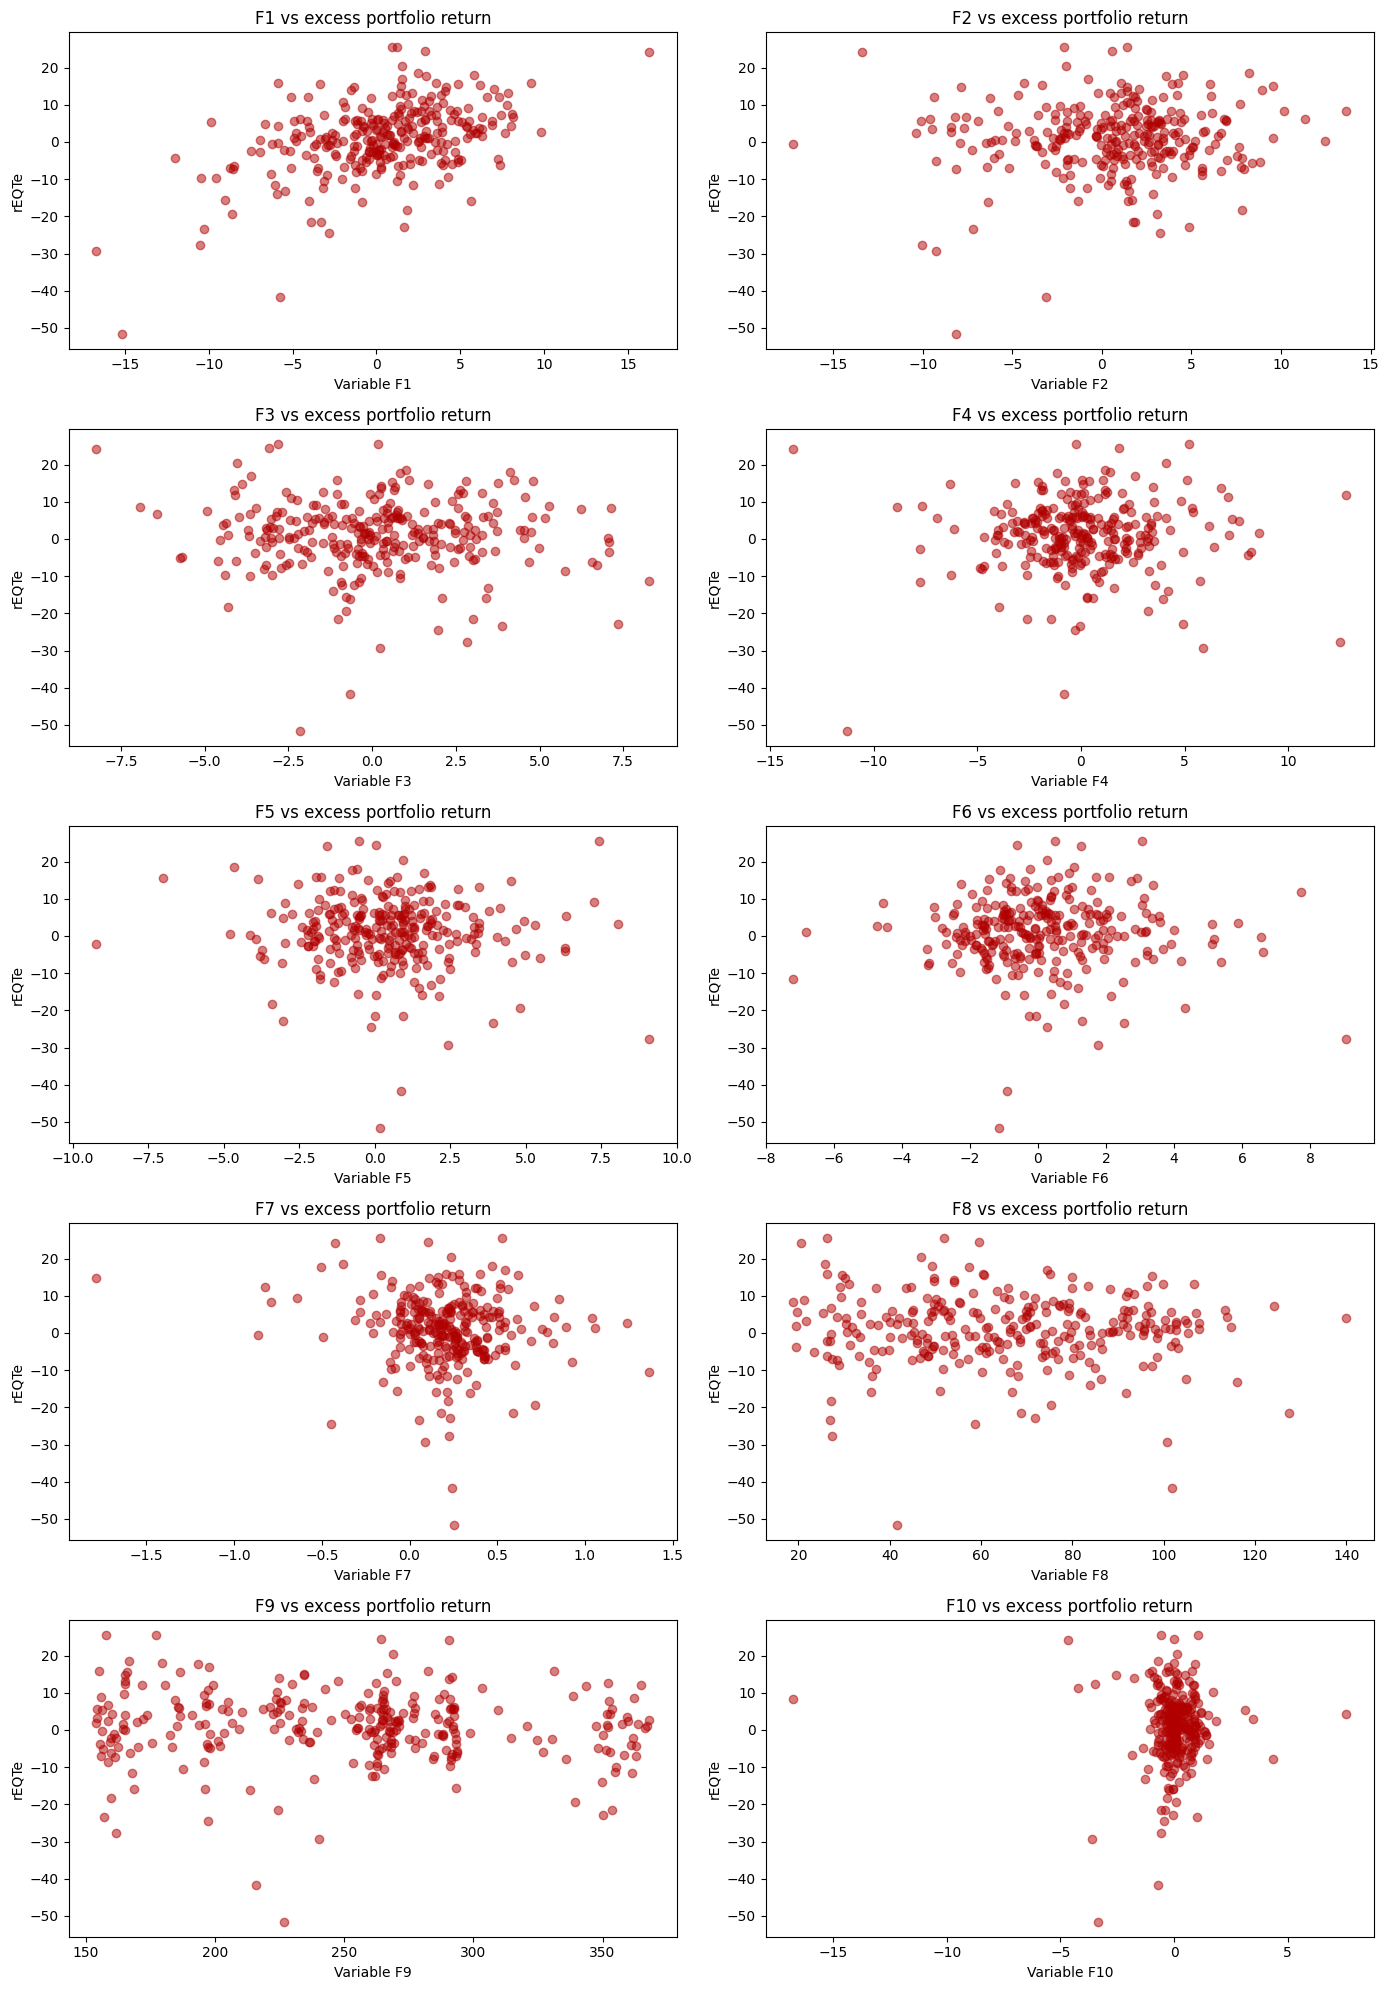

In [14]:
list_scatter= [eMKT[4:], MKT[1:], SMB[1:] , HML[1:] , RMW[1:], CMA[1:], logCPI[1:], OIL[1:], PPI[1:], logIND_PROD[1:]]

# Calculate the number of rows needed with two plots per row (creating an extra row if there's an odd number of equities)
num_rows  = (len(list_scatter)   + 1) // 2  

# Create the figure and axis grid
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 4 * num_rows))
# Flatten the grid for easy indexing
axes      = axes.flatten() 

# Loop through each equity column and create a scatter plot
for i, F in enumerate(list_scatter):
    axes[i].scatter(F, ePortfolio[4:], alpha=0.5, color='#b00000')
    axes[i].set_title(f'F{i+1} vs excess portfolio return')
    axes[i].set_xlabel(f'Variable F{i+1}')
    axes[i].set_ylabel('rEQTe')

# Hide any unused subplots if the number of equities is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Make sure the layout is pretty
plt.tight_layout()
#plt.savefig('Results/.png')
plt.show()

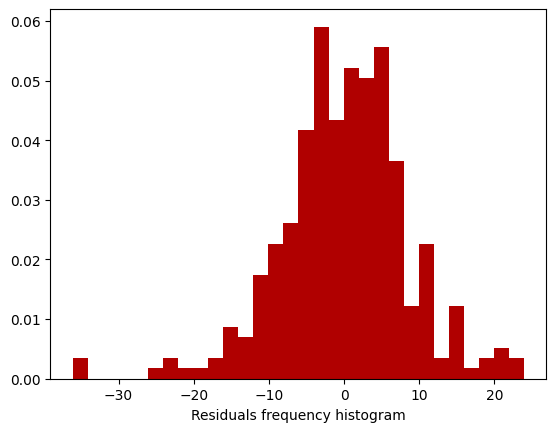

In [15]:
X    = np.column_stack((np.ones_like(eMKT), eMKT))
Res1 = sm.OLS(ePortfolio ,X).fit()
rs1  = Res1.resid

# frequency histogram
plt.hist(rs1, bins=30, density= True, color='#b00000')
plt.xlabel('Residuals frequency histogram')
plt.show()

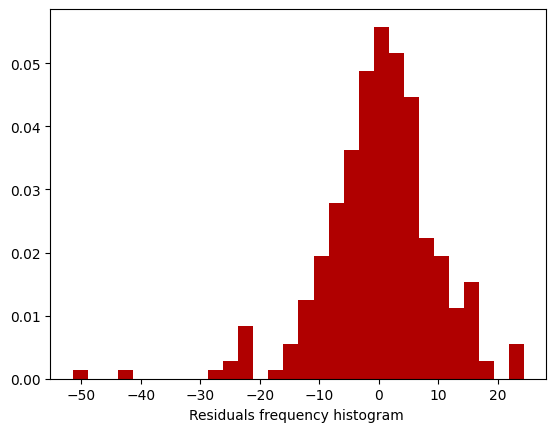

In [16]:
X    = np.column_stack((np.ones_like(Y), MKT[1:], SMB[1:], CMA[1:], logIND_PROD[1:]))
Res2 = sm.OLS(Y, X).fit()
rs2  = Res2.resid
# frequency histogram
plt.hist(rs2, bins=30, density= True, color='#b00000')
plt.xlabel('Residuals frequency histogram ')
plt.show()

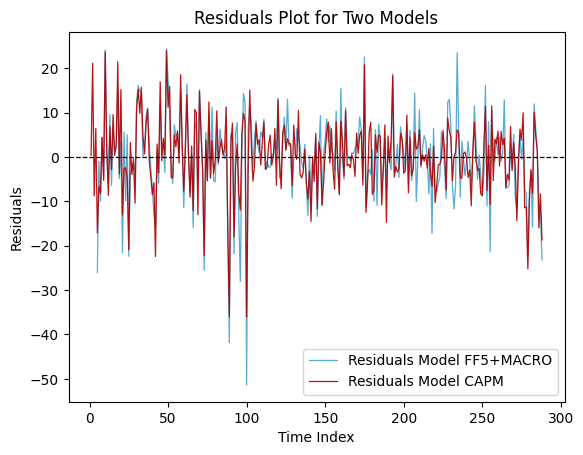

In [17]:
plt.plot(rs2, color='#47a3ce', linewidth=.92, alpha=.9, label='Residuals Model FF5+MACRO')
plt.plot(rs1, color='#b00000', linewidth=.92, alpha=.9, label='Residuals Model CAPM')
plt.title('Residuals Plot for Two Models')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.axhline(0, color='0', linestyle='--', linewidth=.9)
plt.legend()
plt.grid(False)
plt.show()


In [18]:
# Compute the correlation between residuals
correlation_res = np.corrcoef(rs1[4:], rs2)[0, 1]
print(f"Correlation: {correlation_res}")

Correlation: 0.8695506920365804


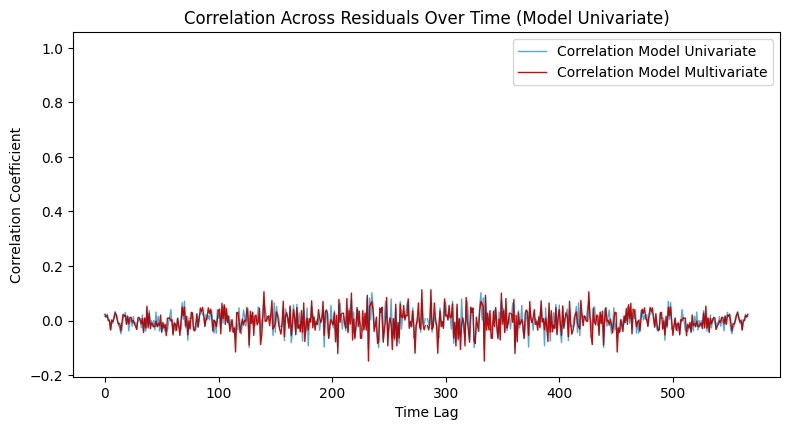

In [19]:
rs1=rs1[4:]
# Calculate the correlation coefficients at each time point for each model
correlation_across_time_model1 = np.correlate(rs1, rs1, mode='full')
correlation_across_time_model2 = np.correlate(rs2, rs2, mode='full')

# Exclude a small neighborhood around the central peak by setting it to NaN

# Normalize the correlation coefficients, excluding NaN values
normalized_correlation_model1 = correlation_across_time_model1 / np.nanmax(np.abs(correlation_across_time_model1))
normalized_correlation_model2 = correlation_across_time_model2 / np.nanmax(np.abs(correlation_across_time_model2))

# Visualize the correlation across residuals over time for each model
plt.figure(figsize=(8, 8))

# Plot correlation across residuals over time for Model 1
plt.subplot(2, 1, 2)
plt.plot(normalized_correlation_model1, color='#47a3ce', alpha=.92, linewidth=1,
        label='Correlation Model Univariate')
plt.plot(np.arange(len(normalized_correlation_model2)), normalized_correlation_model2, color='#b00000', alpha=.92, linewidth=1,
        label='Correlation Model Multivariate')
plt.title('Correlation Across Residuals Over Time (Model Univariate)')
plt.xlabel('Time Lag')
plt.ylabel('Correlation Coefficient')
plt.legend()

#In the midpoint it creates outliers due to its construction, so it was added this for loop that eliminate outliers from the 
#central point of the graph
for ax in plt.gcf().get_axes():
    for line in ax.get_lines():
        y_data = line.get_ydata()
        x_data = line.get_xdata()
        line.set_ydata(np.where(y_data > 0.3, np.nan, y_data))

plt.tight_layout()
plt.show()